# Arabic Handwritten Characters Recognition using Convolutional Neural Network and Support Vector Machine

### COMP6602: Machine Learning I
### Khoula K. Al-Kharusi

Common Imports

In [1]:
import os
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,MaxPooling2D,Conv2D,Dropout,Activation,BatchNormalization
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image, display
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingGridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA,NMF, FactorAnalysis

## Import data and preprocessing

Arabic Charecters list to map the labels with the letters

In [2]:
arabic_chars =list('ابتثجحخدذرزسشصضطظعغفقكلمنهوي')
arabic_chars

['ا',
 'ب',
 'ت',
 'ث',
 'ج',
 'ح',
 'خ',
 'د',
 'ذ',
 'ر',
 'ز',
 'س',
 'ش',
 'ص',
 'ض',
 'ط',
 'ظ',
 'ع',
 'غ',
 'ف',
 'ق',
 'ك',
 'ل',
 'م',
 'ن',
 'ه',
 'و',
 'ي']

In [3]:
x_train = pd.read_csv("/kaggle/input/ahcd1/csvTrainImages 13440x1024.csv",header=None).to_numpy()
y_train = pd.read_csv("/kaggle/input/ahcd1/csvTrainLabel 13440x1.csv",header=None).to_numpy()-1 

x_test = pd.read_csv("/kaggle/input/ahcd1/csvTestImages 3360x1024.csv",header=None).to_numpy()
y_test = pd.read_csv("/kaggle/input/ahcd1/csvTestLabel 3360x1.csv",header=None).to_numpy()-1

print("x_train.shape =", x_train.shape)
print("y_train.shape =", y_train.shape)
print("x_test.shape =", x_test.shape)
print("y_test.shape =", y_test.shape)

x_train.shape = (13440, 1024)
y_train.shape = (13440, 1)
x_test.shape = (3360, 1024)
y_test.shape = (3360, 1)


In [4]:
x_train = x_train.reshape(-1,32,32)
x_test = x_test.reshape(-1,32,32)
x_train = x_train/255
x_test = x_test/255
# for some reason the images are flipped and rotated
# so we transpose each image to be in the correct shape
x_train = np.array([image.T for image in x_train])
x_test = np.array([image.T for image in x_test])

# shuffle
x_train, y_train = shuffle(x_train, y_train)
x_test, y_test = shuffle(x_test, y_test)

print(x_train.shape, x_test.shape)

(13440, 32, 32) (3360, 32, 32)


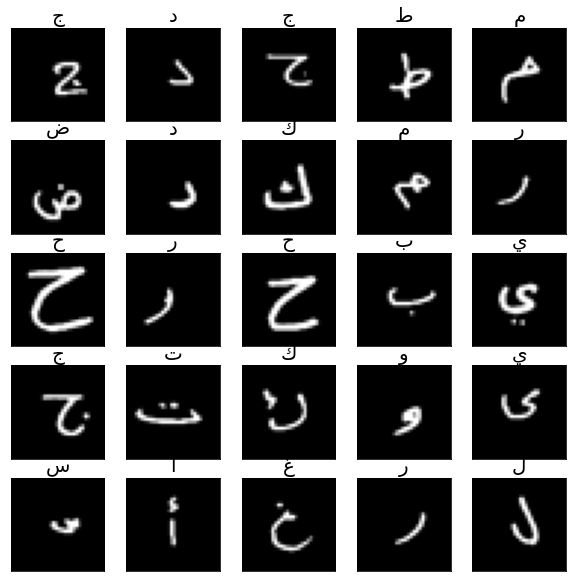

In [5]:
ra = np.random.randint(0, 13440, size=25)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[ra[i]].reshape(32,32),"gray")
    plt.title(arabic_chars[int(y_train[ra[i]][0])], fontsize = 20)
plt.show()

In [6]:
from keras.utils.np_utils import to_categorical
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

y_train_h = to_categorical(y_train)
y_test_h = to_categorical(y_test)

print(y_train.shape, y_test.shape)
print(y_train_h.shape, y_test_h.shape)

(13440,) (3360,)
(13440, 28) (3360, 28)


## ConvNet Model

Using data generater to extend the training set and avoid overfitting

In [7]:
x_train = x_train.reshape(-1,32,32, 1)
x_test = x_test.reshape(-1,32,32, 1)

train_datagen=ImageDataGenerator(
    #rescale=1/255, # Normalize the new images
    zoom_range=0.2, #the amount of zooming u need
    width_shift_range=0.10, # The percentage of Width shifitning
    height_shift_range=0.10, # The percentage of height shifitning
    shear_range=0.1, #Shear angle in counter-clockwise direction in degrees
    fill_mode='nearest',
    rotation_range=20, 
)
train_generator=train_datagen.flow(
    x_train ,y_train ,batch_size=64
)

test_datagen=ImageDataGenerator()
test_generator=test_datagen.flow(
    x_test ,y_test ,batch_size=64
 
)

In [8]:
earlystop = EarlyStopping(patience=6)
learning_rate_reduction=ReduceLROnPlateau(
    monitor='val_acc',
    patience= 3,
    verbose=1,
)
callbacks = [earlystop, learning_rate_reduction]

**The ConvNet architecture is the same proposed in the paper 'Arabic Handwritten Characters Recognition using Convolutional Neural Network'**

![ConvNet Structure](https://www.researchgate.net/profile/Hazem-El-Bakry/publication/313891953/figure/fig4/AS:464684475260928@1487800820810/The-proposed-CNN-for-Arabic-handwritten-character-recognition_W640.jpg)

Elsawy, Ahmed & Loey, Mohamed & El-Bakry, Hazem. (2017). Arabic Handwritten Characters Recognition using Convolutional Neural Network. WSEAS TRANSACTIONS on COMPUTER RESEARCH. 5. 11-19. 

In [9]:
model=Sequential() 

model.add(Conv2D(80,(5,5),activation='relu',input_shape=(32,32,1)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(5,5),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(1024,activation='relu', name='featurs'))
#model.add(Dropout(0.5))
model.add(Dense(28, kernel_regularizer=keras.regularizers.l2(0.01) ,activation='softmax'))

2022-05-08 16:38:41.244074: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 16:38:41.345886: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 16:38:41.346617: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 16:38:41.347748: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [10]:
model.compile(optimizer= 'adam' ,loss='sparse_categorical_crossentropy',metrics=['accuracy'])


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 80)        2080      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 80)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        128064    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
featurs (Dense)              (None, 1024)              1639424   
_________________________________________________________________
dense (Dense)                (None, 28)                2

In [12]:
model.fit(
    train_generator, 
    epochs=50,
    validation_data=test_generator,
    callbacks=callbacks
)

Epoch 1/50


2022-05-08 16:38:43.782365: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-08 16:38:45.181330: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


210/210 [==============================] - 11s 20ms/step - loss: 2.0219 - accuracy: 0.4346 - val_loss: 0.8713 - val_accuracy: 0.7449
Epoch 2/50
210/210 [==============================] - 4s 20ms/step - loss: 1.0098 - accuracy: 0.7147 - val_loss: 0.5522 - val_accuracy: 0.8628
Epoch 3/50
210/210 [==============================] - 4s 19ms/step - loss: 0.7875 - accuracy: 0.7773 - val_loss: 0.4402 - val_accuracy: 0.8830
Epoch 4/50
210/210 [==============================] - 5s 23ms/step - loss: 0.6741 - accuracy: 0.8095 - val_loss: 0.3957 - val_accuracy: 0.9048
Epoch 5/50
210/210 [==============================] - 4s 19ms/step - loss: 0.5881 - accuracy: 0.8405 - val_loss: 0.3639 - val_accuracy: 0.9146
Epoch 6/50
210/210 [==============================] - 4s 20ms/step - loss: 0.5441 - accuracy: 0.8524 - val_loss: 0.4257 - val_accuracy: 0.8866
Epoch 7/50
210/210 [==============================] - 4s 20ms/step - loss: 0.5016 - accuracy: 0.8633 - val_loss: 0.2947 - val_accuracy: 0.9345
Epoch 8/5

<AxesSubplot:>

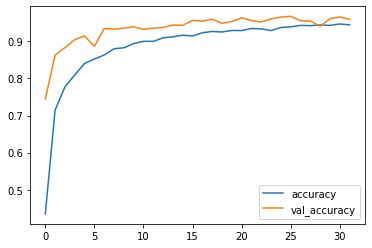

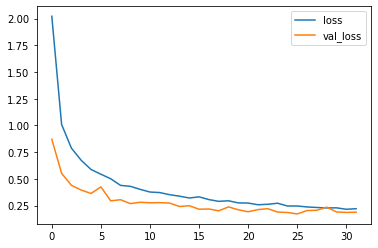

In [13]:
losses = pd.DataFrame(model.history.history)
losses[['accuracy','val_accuracy']].plot()
losses[['loss','val_loss']].plot()

In [14]:
model.evaluate(test_generator)


53/53 [==============================] - 0s 3ms/step - loss: 0.1887 - accuracy: 0.9598


[0.18873482942581177, 0.9598214030265808]

In [15]:
pred = model.predict(x_test)
print(pred.shape)
pred = np.argmax(pred, axis=1)
print(pred)

(3360, 28)
[24  9 13 ... 14  5 14]


In [16]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       120
           1       1.00      0.98      0.99       120
           2       0.94      0.93      0.94       120
           3       0.94      0.99      0.97       120
           4       0.94      1.00      0.97       120
           5       0.99      0.89      0.94       120
           6       0.94      0.97      0.95       120
           7       0.93      0.98      0.96       120
           8       0.96      0.90      0.93       120
           9       0.97      0.97      0.97       120
          10       0.96      0.93      0.94       120
          11       0.96      0.98      0.97       120
          12       0.90      1.00      0.95       120
          13       0.96      0.97      0.97       120
          14       0.99      0.94      0.97       120
          15       1.00      0.94      0.97       120
          16       0.94      0.99      0.96       120
          17       0.99    

## SVM classifier in top of ConvNet

In this part instead if the softmax layer SVM classifier will be used to enhance the classification, the **hybrid SVM and ConvNet** proposed in 2013 by Tang, Yichuan  **Deep Learning using Linear Support Vector Machines**  however in this part non-linear SVM is used. The kernal and other hyper-parameter is estimated using Halving grid-search

#### Getting ConvNet features

In [17]:
from keras.models import Model

layer_name = 'featurs'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
train_features = intermediate_layer_model.predict(x_train)

In [18]:
not train_features.any()

False

#### Halving Grid-search to tune SVM model

In [19]:
from sklearn.svm import SVC
# kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}
grid = {'C': [0.1, 1, 10, 100, 1000],
        'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['linear','rbf', 'poly', 'sigmoid']
       }
svm =SVC()
svm_cv=HalvingGridSearchCV(svm,grid,cv=10)
svm_cv.fit(train_features,y_train)

print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
accuracy : 0.9835317460317461


In [20]:
test_features = intermediate_layer_model.predict(x_test)

#### Using the best parameters we get from the grid search to build the SVM model and train it

In [21]:
svc =SVC(C = 10, gamma = 'scale', kernel = 'rbf')
svc.fit(train_features,y_train)
y_pred = svc.predict(test_features)

#### The Accuracy report of the hybrid model

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       120
           1       0.99      0.99      0.99       120
           2       0.94      0.99      0.97       120
           3       0.99      0.97      0.98       120
           4       0.99      0.99      0.99       120
           5       0.98      0.99      0.98       120
           6       0.98      0.98      0.98       120
           7       0.95      0.97      0.96       120
           8       0.97      0.95      0.96       120
           9       0.94      0.99      0.97       120
          10       0.98      0.94      0.96       120
          11       0.99      1.00      1.00       120
          12       0.98      1.00      0.99       120
          13       0.96      1.00      0.98       120
          14       1.00      0.95      0.97       120
          15       0.98      0.98      0.98       120
          16       0.98      0.97      0.97       120
          17       0.98    

#### ROC AUC Score

In [23]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

# Learn to predict each class against the other
classifier = OneVsRestClassifier(
    SVC(C = 10, gamma = 'scale', kernel = 'rbf')
)
y_score = classifier.fit(train_features,y_train_h).decision_function(test_features)
roc_auc_score(y_test_h, y_score)


0.9988880621693123

In [24]:
print(y_pred)

[24  9 13 ... 14  5 14]


### Misclassification Analysis

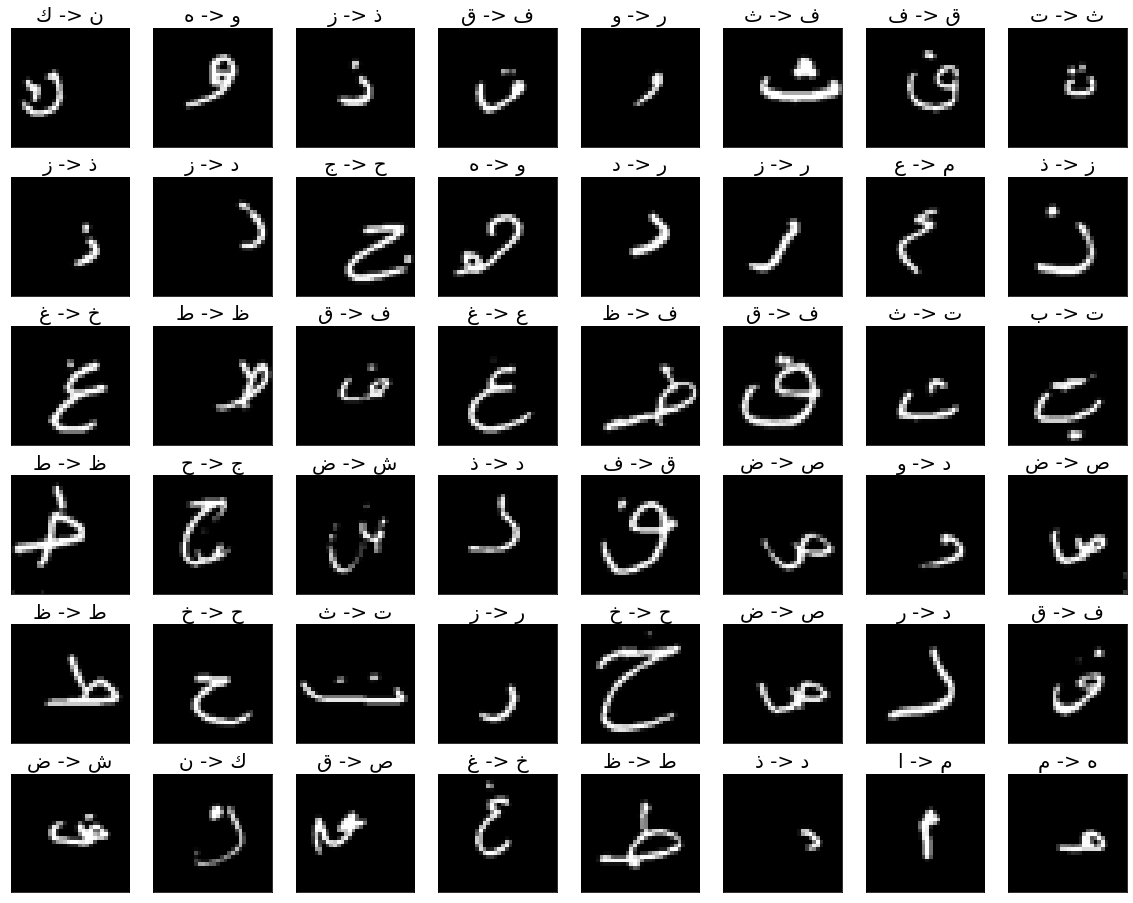

<Figure size 432x288 with 0 Axes>

In [25]:
i = 0 
plt.figure(figsize = (20, 16))
for j in range (len(y_test)):
    if y_test[j] != y_pred[j]:
        plt.subplot(6,8,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(x_test[j].reshape(32,32),"gray")
        plt.title('{} -> {}'.format(arabic_chars[int(y_test[j])], arabic_chars[int(y_pred[j])]), fontsize = 20)
        #plt.xlabel(arabic_chars[int(y_test[j])], fontsize=20)
        i+=1
    if i >= 48:
        break
plt.show()
plt.savefig('misclassified.png')